# Modelling and Evaluation

For the purposes of deploying in a grid ecosystem, we need to consider the specific requirements latency, recall, throughput etc. For faster inference, the models and feature creations should be simple enough, but at the same time, we need to ensure the results of the models are also not affected. 

The feature engineering and modelling has to be optimized to meet he stringent real-time processing, inferencing and accuracy requirements. Hence for comparing models and their performance trade-offs, we will need to use MCC, PR_AUC and Latency across models to balance inference latency with detection accuracy .

## Models Considered

* Tier 1: Ultra Fast: Logistic Regression and XGBoost with min estimators
* Tier 2: Fast: CatBoost, Random Forest
* Tier 3: XGBoost with higher number of estimators, LSTM (Not implemented in this notebook)

## Metrics Used for Comparison and Optimization

1. Matthew’s Correlation Coefficient
	* Provides balanced assessment of binary classifier when working with imbalanced dataset
2. Precision-Recall Area Under Curve (PR_AUC)
	* Focuses on Positive Class performance critical to fault detection
	* Shows trade-off between catching faults (recall) vs minimizing false alarms (precision)
3. Latency
	* To manage the real-time requirements in power system grids, the processing and inference time has to be in smaller ms to prevent cascading failures and equipment damage
	* Edge devices also have limited computational resources, making inference speed as critical as accuracy in real-time
4. Other Metrics
	* The regular metrics like F1, Precision, Recall, ROC AUC, Accuracy etc. might not be individually suitable for evaluating model performance. We will still visualize them for all models, but the model selection will be based on MCC, PR-AUC and Latency

### Based on the compared models and model performance metrics, the best model is selected at the end of this step

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, roc_curve, matthews_corrcoef,
                           precision_score, recall_score, f1_score, accuracy_score,average_precision_score)
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time
import psutil
import warnings
warnings.filterwarnings('ignore')

# Imports from Helper functions
from helper.evaluations import measure_latency, measure_training_latency, measure_inference_latency, plot_model_comparison_with_latency
from helper.evaluations import plot_latency_accuracy_tradeoff, plot_model_comparison, plot_confusion_matrices, plot_roc_curves,plot_multiple_pr_curves
from helper.evaluations import get_feature_importance, plot_feature_importance
from helper.load_save_model import quick_save_models,save_best_performing_model
from helper.common import prepare_data

In [2]:
DATA_PATH = r'./data/vsb-power-line-fault-detection/'
FEATURE_PATH = r"./features//"
MODEL_PATH = r"./models//"
CHUNK_SIZE = 1000
SAMPLE_SIZE=1000

### Data Preparation for Training & Evaluation

In [3]:
# Load and prepare data with optimized features
feature_df  = pd.read_parquet(f"{FEATURE_PATH}/final_features.parquet")

In [4]:
data_splits = prepare_data(feature_df, target_col='target',random_state=123)

Preparing data for model training...
Feature matrix shape: (5000, 124)
Target distribution:
target
0    0.9336
1    0.0664
Name: proportion, dtype: float64
Training set: 3200 samples
Validation set: 800 samples
Test set: 1000 samples


### Model Definitions

In [5]:
random_state=123
models = {
        # Tier 1: Faster Models
        'logistic_regression': LogisticRegression(
            random_state=random_state,
            max_iter=1000,
            class_weight='balanced',
            solver='liblinear'  # Faster for small datasets
        ),
              
        'xgboost_fast': xgb.XGBClassifier(
            random_state=random_state,
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=50,  # Reduced for speed
            max_depth=6,
            subsample=0.8
        ),
        
        # Tier 2: Balanced accuracy-speed models 
        'catboost_fast': CatBoostClassifier(
            random_state=random_state,
            verbose=False,
            iterations=100,  # Reduced for speed
            depth=6,
            class_weights=[1, 3]  # Handle class imbalance
        ),
        
        'random_forest_fast': RandomForestClassifier(
            n_estimators=50,  # Reduced for speed
            max_depth=10,
            random_state=random_state,
            class_weight='balanced',
            n_jobs=-1
        ),
        
     
        'xgboost_accurate': xgb.XGBClassifier(
            random_state=random_state,
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=200,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8
        )
    }
    

### Model Training & Cross Validation

In [6]:
def train_models(data_splits, cv_folds=5, measure_latency=True,models=models):
    """
    Train optimized models for grid applications
    
    Args:
        data_splits: Dictionary containing data splits
        cv_folds: Number of cross-validation folds
        measure_latency: Whether to measure training and inference latency
        
    Returns:
        dict: Training results
    """
    print("Training optimized models for grid applications...")
    
    results = {}
    
    X_train = data_splits['X_train']
    y_train = data_splits['y_train']
    X_val = data_splits['X_val']
    y_val = data_splits['y_val']
    
    X_train_selected = X_train
    X_val_selected = X_val
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        try:
            # Measure training time
            if measure_latency:
                training_start = time.perf_counter()
            
            # Train model
            model.fit(X_train_selected, y_train)
            
            if measure_latency:
                training_end = time.perf_counter()
                training_time = (training_end - training_start) * 1000  # ms
            
            # Predictions
            y_pred_train = model.predict(X_train_selected)
            y_pred_val = model.predict(X_val_selected)
            y_pred_proba_train = model.predict_proba(X_train_selected)[:, 1] if hasattr(model, 'predict_proba') else y_pred_train
            y_pred_proba_val = model.predict_proba(X_val_selected)[:, 1] if hasattr(model, 'predict_proba') else y_pred_val
            
            # Calculate metrics
            results[name] = {
                'model': model,
                'train_accuracy': accuracy_score(y_train, y_pred_train),
                'val_accuracy': accuracy_score(y_val, y_pred_val),
                'train_f1': f1_score(y_train, y_pred_train),
                'val_f1': f1_score(y_val, y_pred_val),
                'train_precision': precision_score(y_train, y_pred_train),
                'val_precision': precision_score(y_val, y_pred_val),
                'train_recall': recall_score(y_train, y_pred_train),
                'val_recall': recall_score(y_val, y_pred_val),
                'train_mcc': matthews_corrcoef(y_train, y_pred_train),
                'val_mcc': matthews_corrcoef(y_val, y_pred_val),
                'train_auc': roc_auc_score(y_train, y_pred_proba_train),
                'val_auc': roc_auc_score(y_val, y_pred_proba_val),
                'train_pr_auc': average_precision_score(y_train, y_pred_proba_train),
                'val_pr_auc': average_precision_score(y_val, y_pred_proba_val),
                'y_pred_val': y_pred_val,
                'y_pred_proba_val': y_pred_proba_val
            }
            
            # Add latency measurements
            if measure_latency:
                results[name]['training_time_ms'] = training_time
                
                # Measure inference latency for different batch sizes
                print(f"  Measuring inference latency for {name}...")
                inference_latency = measure_inference_latency(model, X_val_selected, 
                                                                 batch_sizes=[1, 10, 100])
                results[name]['inference_latency'] = inference_latency
                
                # Add single sample latency for quick reference
                if 'batch_1' in inference_latency:
                    results[name]['single_sample_latency_ms'] = inference_latency['batch_1']['per_sample_predict_ms']
                    results[name]['single_sample_proba_latency_ms'] = inference_latency['batch_1']['per_sample_proba_ms']
                    results[name]['throughput_samples_per_sec'] = inference_latency['batch_1']['throughput_samples_per_sec']
            
            # Cross-validation score
            if cv_folds > 1:
                cv_scores = cross_val_score(model, X_train_selected, y_train, cv=cv_folds, 
                                          scoring='matthews_corrcoef')
                results[name]['cv_mcc_mean'] = cv_scores.mean()
                results[name]['cv_mcc_std'] = cv_scores.std()
            
            print(f"  Validation MCC: {results[name]['val_mcc']:.4f}")
            print(f"  Validation AUC: {results[name]['val_auc']:.4f}")
            print(f"  Validation PR AUC: {results[name]['val_auc']:.4f}")
            if measure_latency:
                print(f"  Training time: {training_time:.1f} ms")
                if 'single_sample_latency_ms' in results[name]:
                    print(f"  Single sample inference: {results[name]['single_sample_latency_ms']:.3f} ms")
                    print(f"  Throughput: {results[name]['throughput_samples_per_sec']:.0f} samples/sec")
            
        except Exception as e:
            print(f"  Error training {name}: {str(e)}")
            results[name] = {'error': str(e)}
    
    results.update(results)
    return results

In [7]:
results = train_models(data_splits, cv_folds=5, measure_latency=True,models=models)

Training optimized models for grid applications...

Training logistic_regression...
  Measuring inference latency for logistic_regression...
  Validation MCC: 0.4232
  Validation AUC: 0.8807
  Validation PR AUC: 0.8807
  Training time: 147.7 ms
  Single sample inference: 0.687 ms
  Throughput: 1455 samples/sec

Training xgboost_fast...
  Measuring inference latency for xgboost_fast...
  Validation MCC: 0.4689
  Validation AUC: 0.9305
  Validation PR AUC: 0.9305
  Training time: 273.8 ms
  Single sample inference: 5.244 ms
  Throughput: 191 samples/sec

Training catboost_fast...
  Measuring inference latency for catboost_fast...
  Validation MCC: 0.5457
  Validation AUC: 0.9368
  Validation PR AUC: 0.9368
  Training time: 1249.7 ms
  Single sample inference: 1.135 ms
  Throughput: 881 samples/sec

Training random_forest_fast...
  Measuring inference latency for random_forest_fast...
  Validation MCC: 0.5541
  Validation AUC: 0.9333
  Validation PR AUC: 0.9333
  Training time: 234.4 ms
 

### Model Evaluation

Since we have imbalanced datasets and we are looking to optimize positive class and at the same time latency is important for grid deployment, the three most important metrics for this use case are:

1. Mathew's Correlation Coefficient (MCC)
2. Precision Recall Area Under the Curve (PR-AUC)
3. Latency

In [8]:
def evaluate_for_grid_deployment(data_splits, latency_threshold_ms=10, min_mcc=0.3, min_pr_auc =0.4):
    """
    Evaluate models specifically for grid deployment requirements
    
    Args:
        data_splits: Dictionary containing data splits
        latency_threshold_ms: Maximum acceptable inference latency
        min_mcc: Minimum acceptable MCC score
        
    Returns:
        pd.DataFrame: Grid deployment evaluation results
    """
    print(f"\nEvaluating models for grid deployment...")
    print(f"Requirements: Latency < {latency_threshold_ms}ms, MCC > {min_mcc}, PR AUC > {min_pr_auc}")
    
    evaluation_results = []
    
    X_test = data_splits['X_test']
    y_test = data_splits['y_test']
    
    X_test_selected = X_test
    
    for model_name, result in results.items():
        if 'error' in result:
            continue
            
        try:
            model = result['model']
            
            # Test set predictions using same feature selection
            y_pred_test = model.predict(X_test_selected)
            y_pred_proba_test = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, 'predict_proba') else y_pred_test
            
            # Calculate test metrics
            test_mcc = matthews_corrcoef(y_test, y_pred_test)
            test_auc = roc_auc_score(y_test, y_pred_proba_test)
            test_pr_auc = average_precision_score(y_test, y_pred_proba_test)
            test_f1 = f1_score(y_test, y_pred_test)
            test_precision = precision_score(y_test, y_pred_test)
            test_recall = recall_score(y_test, y_pred_test)
            test_accuracy = accuracy_score(y_test, y_pred_test)

            # Get latency info
            single_latency = result.get('single_sample_latency_ms', float('inf'))
            throughput = result.get('throughput_samples_per_sec', 0)
            
            # Grid deployment suitability
            meets_latency = single_latency <= latency_threshold_ms
            meets_accuracy = test_mcc >= min_mcc
            meets_precision = test_pr_auc >= min_pr_auc
            grid_suitable = meets_latency and meets_accuracy and meets_precision
            
            # Calculate grid readiness score (0-100)
            latency_score = max(0, 100 * (latency_threshold_ms - single_latency) / latency_threshold_ms)
            accuracy_score_calc = min(100, 100 * test_mcc / 0.8)  # Scale to 0.8 as excellent MCC
            grid_score = (latency_score + accuracy_score_calc) / 2
            
            evaluation_results.append({
                'model': model_name,
                'model_tier': result.get('model_tier', 'Unknown'),
                'test_mcc': test_mcc,
                'test_auc': test_auc,
                'test_pr_auc':test_pr_auc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_accuracy': test_accuracy,
                'val_mcc': result.get('val_mcc', 0),
                'single_latency_ms': single_latency,
                'throughput_per_sec': throughput,
                'meets_latency': meets_latency,
                'meets_accuracy': meets_accuracy,
                'grid_suitable': grid_suitable,
                'grid_readiness_score': grid_score,
                'training_time_ms': result.get('training_time_ms', 0)
            })
            
        except Exception as e:
            print(f"Error evaluating {model_name}: {e}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    if not results_df.empty:
        # Sort by grid readiness score
        results_df = results_df.sort_values('grid_readiness_score', ascending=False)
        
        print(f"\nGrid Deployment Evaluation Results:")
        print("="*60)
        
        # Show suitable models
        suitable_models = results_df[results_df['grid_suitable']]
        if len(suitable_models) > 0:
            print(f"✓ {len(suitable_models)} models meet grid requirements:")
            for _, row in suitable_models.head(3).iterrows():
                print(f"  {row['model']}: MCC={row['test_mcc']:.3f},PR-AUC={row['test_pr_auc']:.3f}, Latency={row['single_latency_ms']:.2f}ms, Score={row['grid_readiness_score']:.1f}")
        else:
            print("⚠ No models fully meet grid requirements")
            print("Consider relaxing constraints or using feature selection")
        
        # Show performance trade-offs
        print(f"\nPerformance Trade-offs:")
        fastest_model = results_df.loc[results_df['single_latency_ms'].idxmin()]
        most_accurate = results_df.loc[results_df['test_mcc'].idxmax()]
        most_precise_recall = results_df.loc[results_df['test_pr_auc'].idxmax()]
        
        print(f"Fastest: {fastest_model['model']} ({fastest_model['single_latency_ms']:.2f}ms, MCC={fastest_model['test_mcc']:.3f},PR-AUC={fastest_model['test_pr_auc']:.3f})")
        print(f"Most Accurate: {most_accurate['model']} (MCC={most_accurate['test_mcc']:.3f}, {most_accurate['single_latency_ms']:.2f}ms),PR-AUC={most_accurate['test_pr_auc']:.3f}")
        print(f"Best PR AUC: {most_precise_recall['model']} (PR-AUC={row['test_pr_auc']:.3f},MCC={most_precise_recall['test_mcc']:.3f}, {most_precise_recall['single_latency_ms']:.2f}ms)")
    
    
    return results_df

In [20]:
grid_evaluation_df  = evaluate_for_grid_deployment(data_splits, latency_threshold_ms=10, min_mcc=0.4)


Evaluating models for grid deployment...
Requirements: Latency < 10ms, MCC > 0.4, PR AUC > 0.4

Grid Deployment Evaluation Results:
✓ 2 models meet grid requirements:
  logistic_regression: MCC=0.432,PR-AUC=0.405, Latency=0.69ms, Score=73.6
  catboost_fast: MCC=0.442,PR-AUC=0.516, Latency=1.13ms, Score=71.9

Performance Trade-offs:
Fastest: logistic_regression (0.69ms, MCC=0.432,PR-AUC=0.405)
Most Accurate: random_forest_fast (MCC=0.475, 16.54ms),PR-AUC=0.510
Best PR AUC: catboost_fast (PR-AUC=0.516,MCC=0.442, 1.13ms)


### Model Performance Comparison

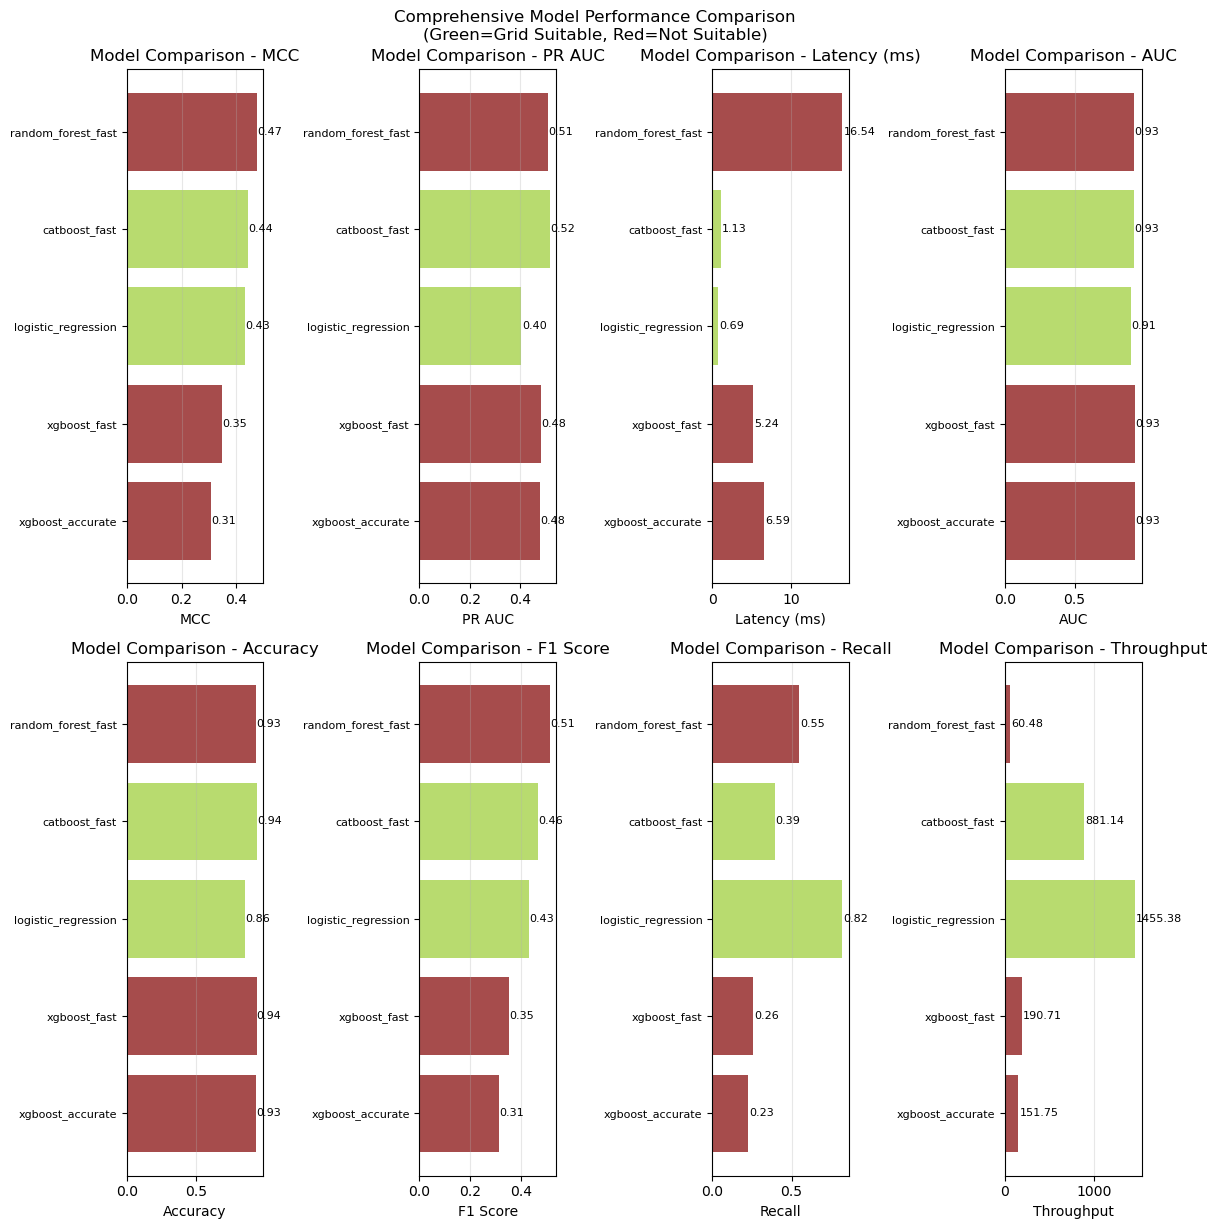

In [21]:
plot_model_comparison_with_latency(grid_evaluation_df)

### Latency Vs Accuracy Trade Off

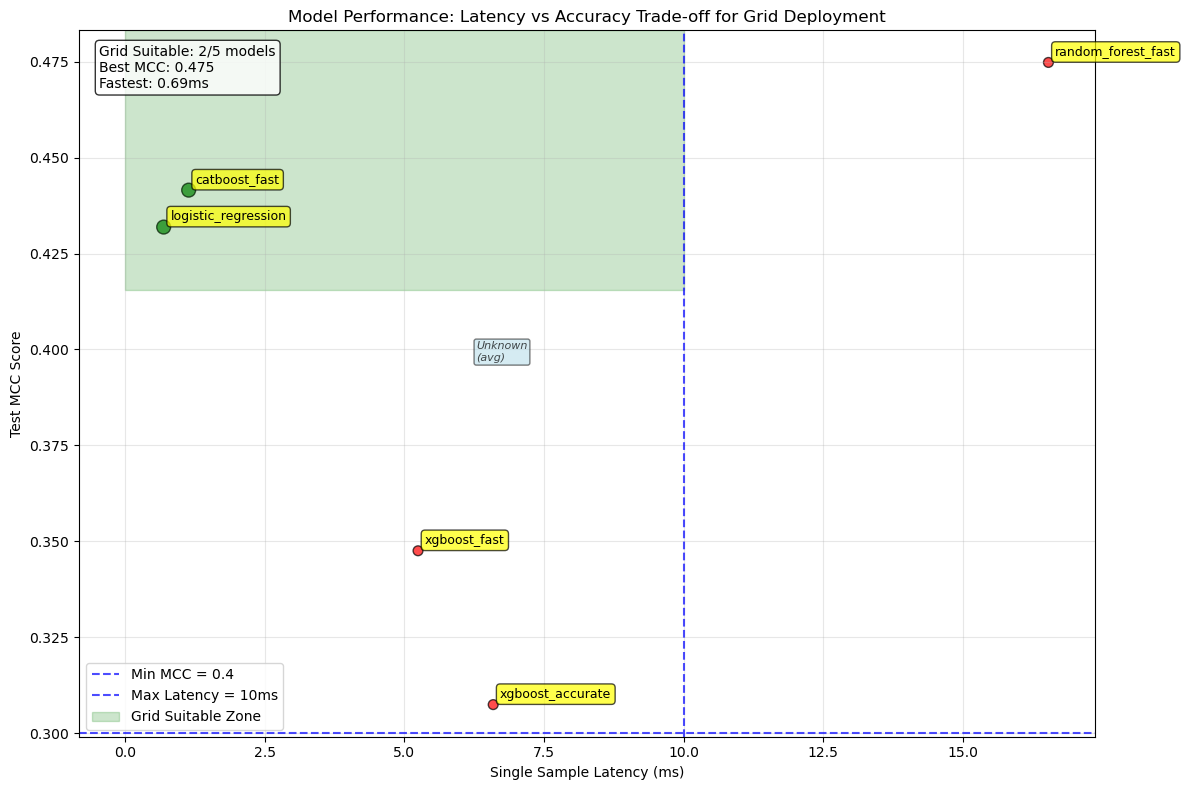

In [22]:
plot_latency_accuracy_tradeoff(grid_evaluation_df)

In [12]:
# plot_model_comparison(grid_evaluation_df)

### Confusion Matrix

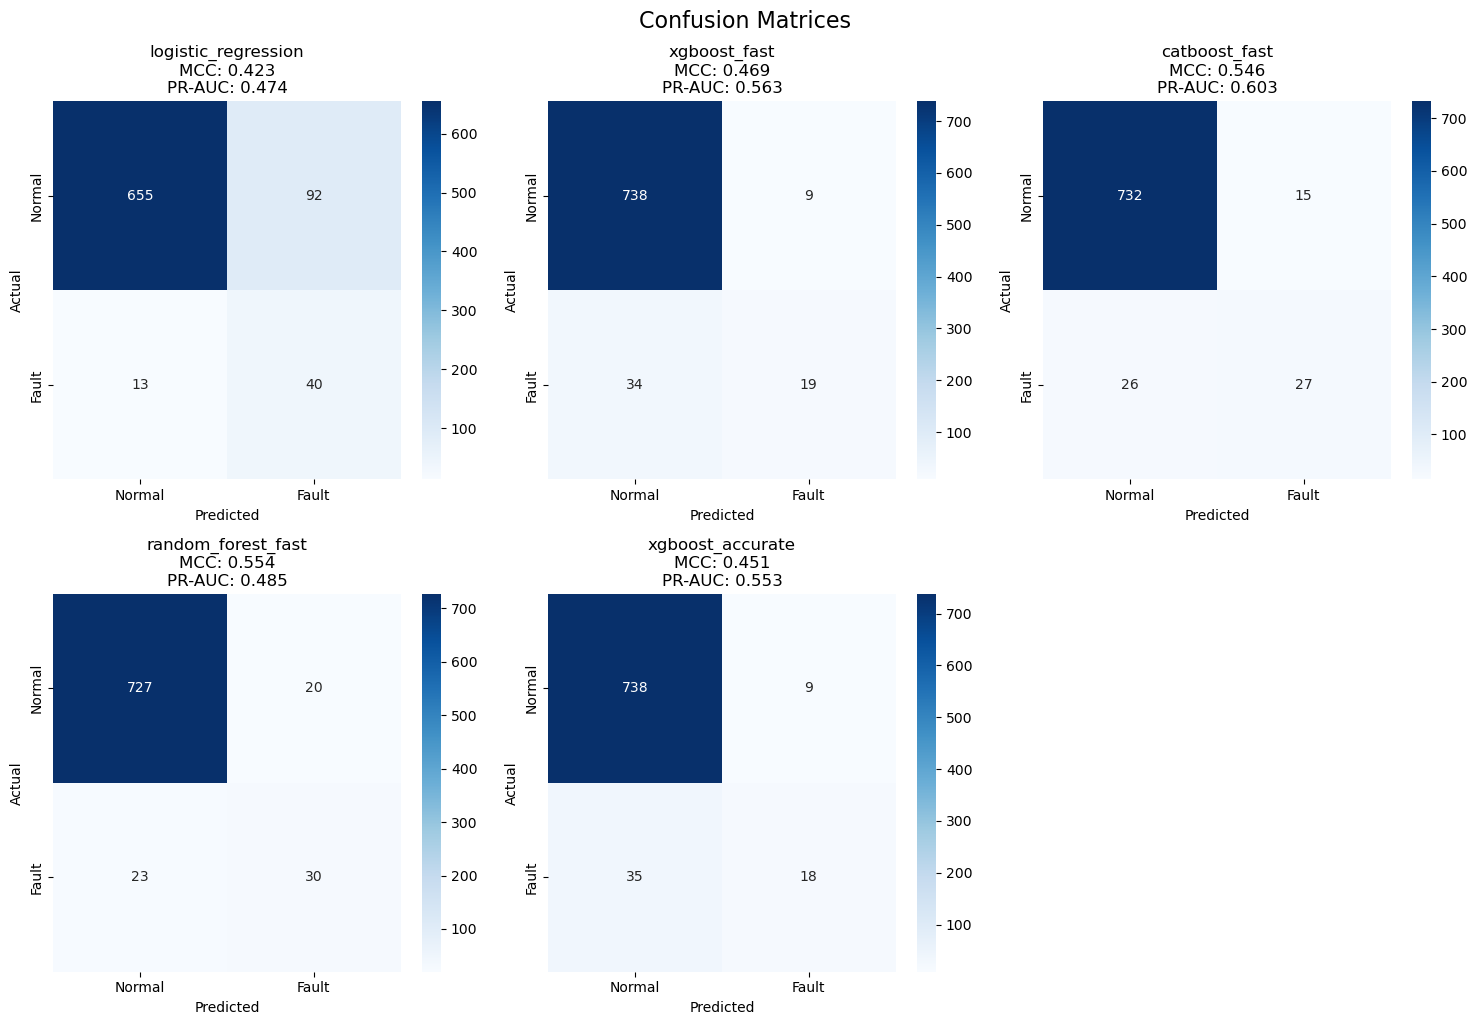

In [13]:
plot_confusion_matrices(data_splits,results,models)

### ROC AUC Curves

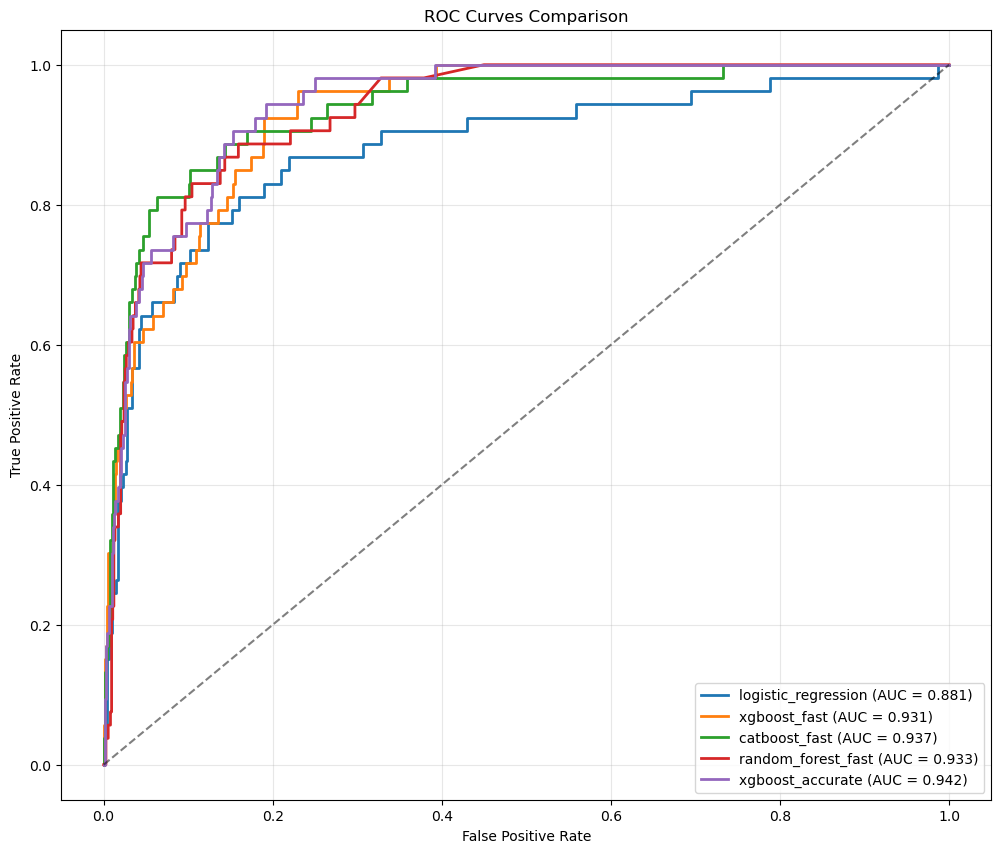

In [14]:
plot_roc_curves(data_splits,results, models)

### Precision Recall - AUC Curve

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'PR-AUC Curves Comparison'}, xlabel='Recall', ylabel='Precision'>,
 {'logistic_regression': 0.4047241311657025,
  'xgboost_fast': 0.4811775346922429,
  'catboost_fast': 0.5164046264695101,
  'random_forest_fast': 0.5098911207681499,
  'xgboost_accurate': 0.47725771617032564})

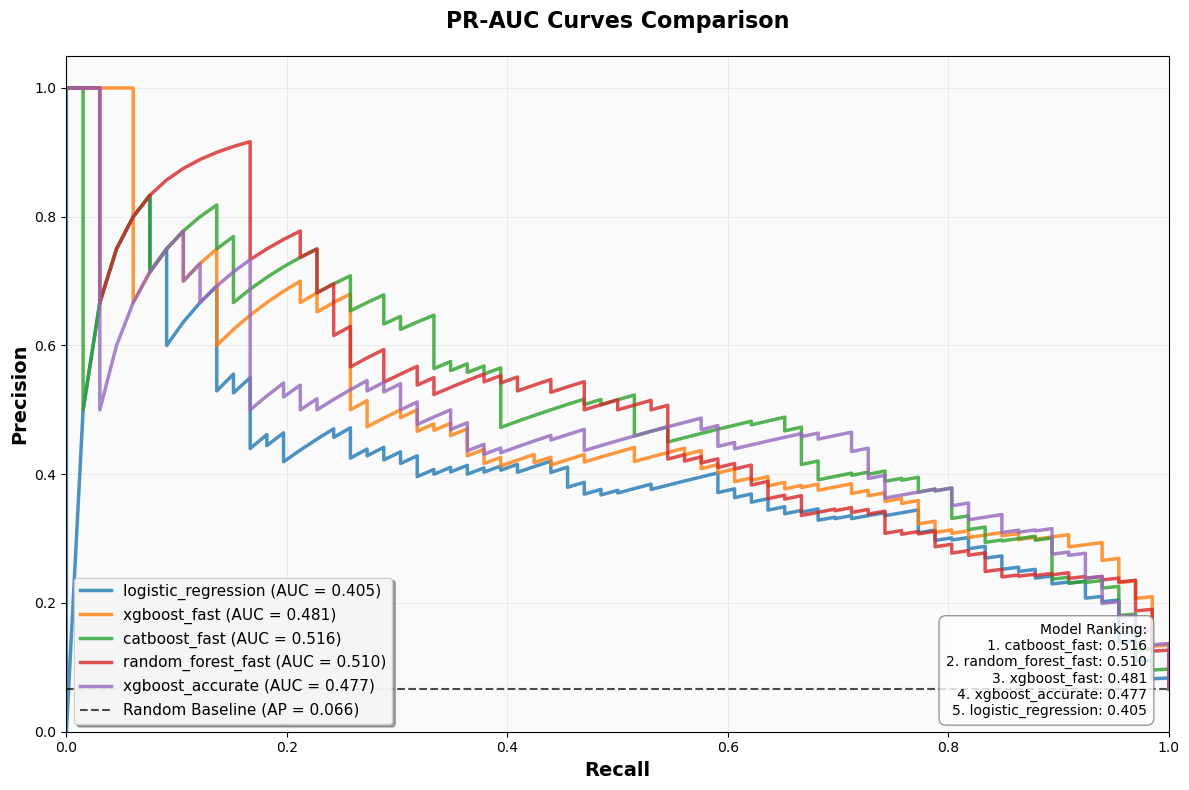

In [15]:
y_true_list = []
y_scores_list = []
model_names = []
for name,model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(data_splits['X_test'])[:, 1]
    else:
        y_scores = model.predict(data_splits['X_test'])
    
    # Store results
    y_true_list.append(data_splits['y_test'])
    y_scores_list.append(y_scores)
    model_names.append(name)
plot_multiple_pr_curves(y_true_list, y_scores_list, model_names)

#### Catboost presents the best PR AUC value followed by Random Forest

### Top 20 Most Important Features by BEST Model

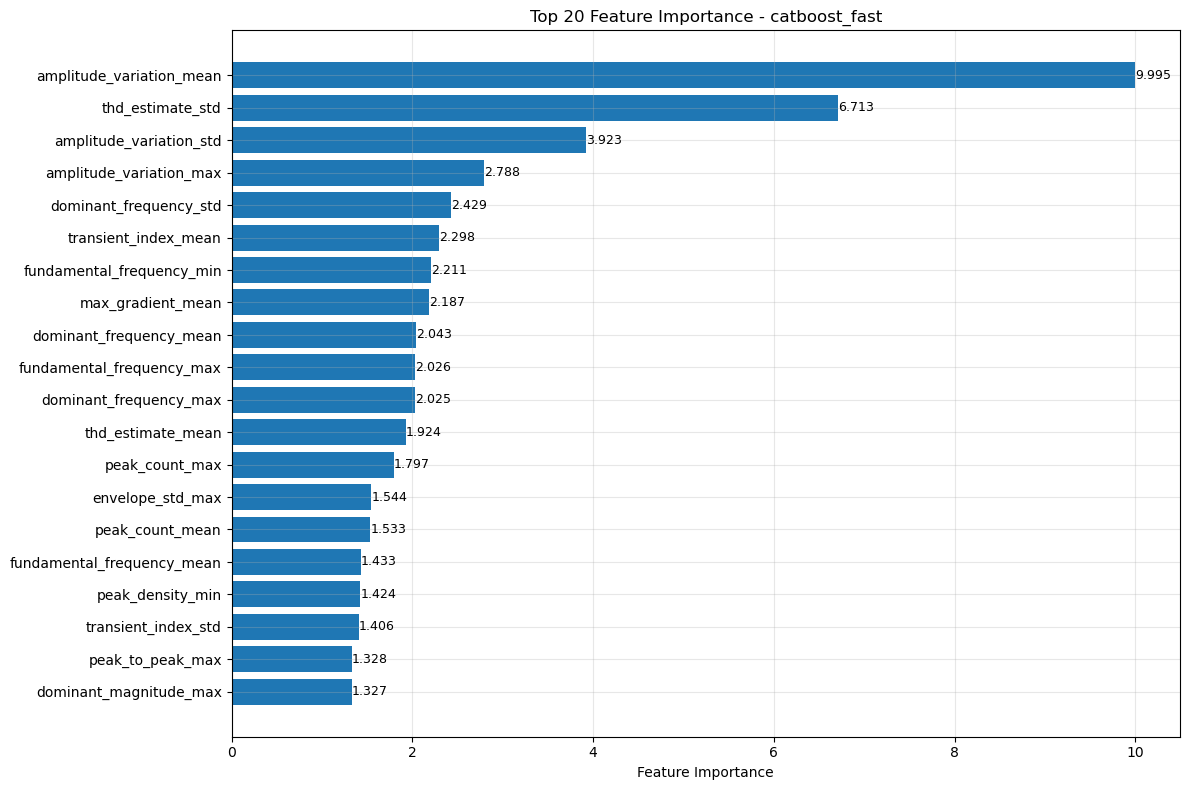

,feature,importance
120,amplitude_variation_mean,9.994617
105,thd_estimate_std,6.713415
121,amplitude_variation_std,3.923224
123,amplitude_variation_max,2.788097
73,dominant_frequency_std,2.429029
112,transient_index_mean,2.297620
110,fundamental_frequency_min,2.210640
116,max_gradient_mean,2.187314
72,dominant_frequency_mean,2.042702
111,fundamental_frequency_max,2.026398


In [16]:
feature_names=data_splits['X_train'].columns

plot_feature_importance('catboost_fast', results,feature_names, top_n=20, figsize=(12, 8))

As we saw in the EDA, highly distinguising features are related to 
1. _Amplitude_ vvariations are extremes for fault signals
2. _THD (Total Harmonic Distortion)_ showcasing distortions in the signal for fault signals
3. _Dominant Frequency_ shifts to harmonics or sub-harmonics for fault signals
4. _Transient Index_ high-frequency oscillations become dominant for fault signals

### Saving the Models

In [17]:
saved_info = quick_save_models(models, data_splits['X_test'], data_splits['y_test'])

Saving 5 models to: models\models_20250928_173550
--------------------------------------------------
✓ Saved model: logistic_regression_20250928_173550.pkl
  Performance: MCC=0.432, AUC=0.906
  Latency: 1.28ms
  Metadata: logistic_regression_metadata_20250928_173550.json
✓ Saved model: xgboost_fast_20250928_173550.pkl
  Performance: MCC=0.348, AUC=0.932
  Latency: 6.81ms
  Metadata: xgboost_fast_metadata_20250928_173550.json
✓ Saved model: catboost_fast_20250928_173551.pkl
  Performance: MCC=0.442, AUC=0.928
  Latency: 2.84ms
  Metadata: catboost_fast_metadata_20250928_173551.json
✗ Failed to save catboost_fast: [Errno 2] No such file or directory: 'models\\models_20250928_173550\\catboost_fast_metadata_20250928_173550.json'
✓ Saved model: random_forest_fast_20250928_173551.pkl
  Performance: MCC=0.475, AUC=0.926
  Latency: 19.60ms
  Metadata: random_forest_fast_metadata_20250928_173551.json
✗ Failed to save random_forest_fast: [Errno 2] No such file or directory: 'models\\models_20250

### Saving the Best model

In [18]:
# Or save best model only
best_model_path = save_best_performing_model(
    models_dict=models,
    X_test=data_splits['X_test'], 
    y_test=data_splits['y_test'],
    metric='prauc'  # Choose: 'mcc', 'auc', 'f1', 'accuracy'
)

Evaluating 5 models to find best by PRAUC...
  logistic_regression: PRAUC=0.4047
  xgboost_fast: PRAUC=0.4812
  catboost_fast: PRAUC=0.5164
  random_forest_fast: PRAUC=0.5099
  xgboost_accurate: PRAUC=0.4773

Best model: catboost_fast (PRAUC=0.5164)
✓ Saved model: best_model_catboost_fast_20250928_173554.pkl
  Performance: MCC=0.442, AUC=0.928
  Latency: 2.25ms
  Metadata: best_model_catboost_fast_metadata_20250928_173554.json


In [19]:
print("Best model is Saved at:",best_model_path)

Best model is Saved at: saved_models\best_model_catboost_fast_20250928_173554.pkl


### End of Modelling and Evaluation